In [1]:
from tqdm import tqdm
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Custom colors
class clr:
    S = '\033[1m' + '\033[92m'
    E = '\033[0m'
    
my_colors = ["#CC5547", "#DB905D", "#D9AE6C", "#93AF5C", "#799042", "#61783F"]

In [2]:
train_data = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")
train_data['case'] = train_data['id'].apply(lambda x: x.split('_')[0])
train_data['day'] = train_data['id'].apply(lambda x: x.split('_')[1])
train_data['slice'] = train_data['id'].apply(lambda x: x.split('_')[2] + '_' + x.split('_')[3])

In [3]:
print("Total Rows : ", train_data.shape[0])
print("Total Unique Cases : ", len(train_data['id'].unique()))
print("Missing Value Column : ", train_data.isna().sum().index[2])
print("\tMissing Values : ", train_data.isna().sum()[2])
print('\nUnique classes:', train_data['class'].unique())
print('# Images per class:\n')
print('# Images with segmentation:', train_data[train_data['segmentation'].notna()]['id'].nunique(), '(' + str(round(train_data[train_data['segmentation'].notna()]['id'].nunique()/train_data['id'].nunique() * 100,2)) + ' % out of',str(train_data['id'].nunique()) + ')')
train_data.groupby(['class']).agg({'id':'nunique','segmentation':'count'}).reset_index().rename(columns = {'id':'# Images','segmentation':'# Images with annotation'})

Total Rows :  115488
Total Unique Cases :  38496
Missing Value Column :  segmentation
	Missing Values :  81575

Unique classes: ['large_bowel' 'small_bowel' 'stomach']
# Images per class:

# Images with segmentation: 16590 (43.1 % out of 38496)


class  # Images  # Images with annotation
0  large_bowel     38496                     14085
1  small_bowel     38496                     11201
2      stomach     38496                      8627

In [4]:
train_data.head()

id        class segmentation     case    day  \
0  case123_day20_slice_0001  large_bowel          NaN  case123  day20   
1  case123_day20_slice_0001  small_bowel          NaN  case123  day20   
2  case123_day20_slice_0001      stomach          NaN  case123  day20   
3  case123_day20_slice_0002  large_bowel          NaN  case123  day20   
4  case123_day20_slice_0002  small_bowel          NaN  case123  day20   

        slice  
0  slice_0001  
1  slice_0001  
2  slice_0001  
3  slice_0002  
4  slice_0002

In [5]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
# Functions to get image width and height
def get_img_size(x, flag):
    
    if x != 0:
        split = x.split("_")
        width = split[3]
        height = split[4]
    
        if flag == "width":
            return int(width)
        elif flag == "height":
            return int(height)
    
    return 0


def get_pixel_size(x, flag):
    
    if x != 0:
        split = x.split("_")
        width = split[-2]
        height = ".".join(split[-1].split(".")[:-1])
    
        if flag == "width":
            return float(width)
        elif flag == "height":
            return float(height)
    
    return 0

# Custom color map in matplotlib
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

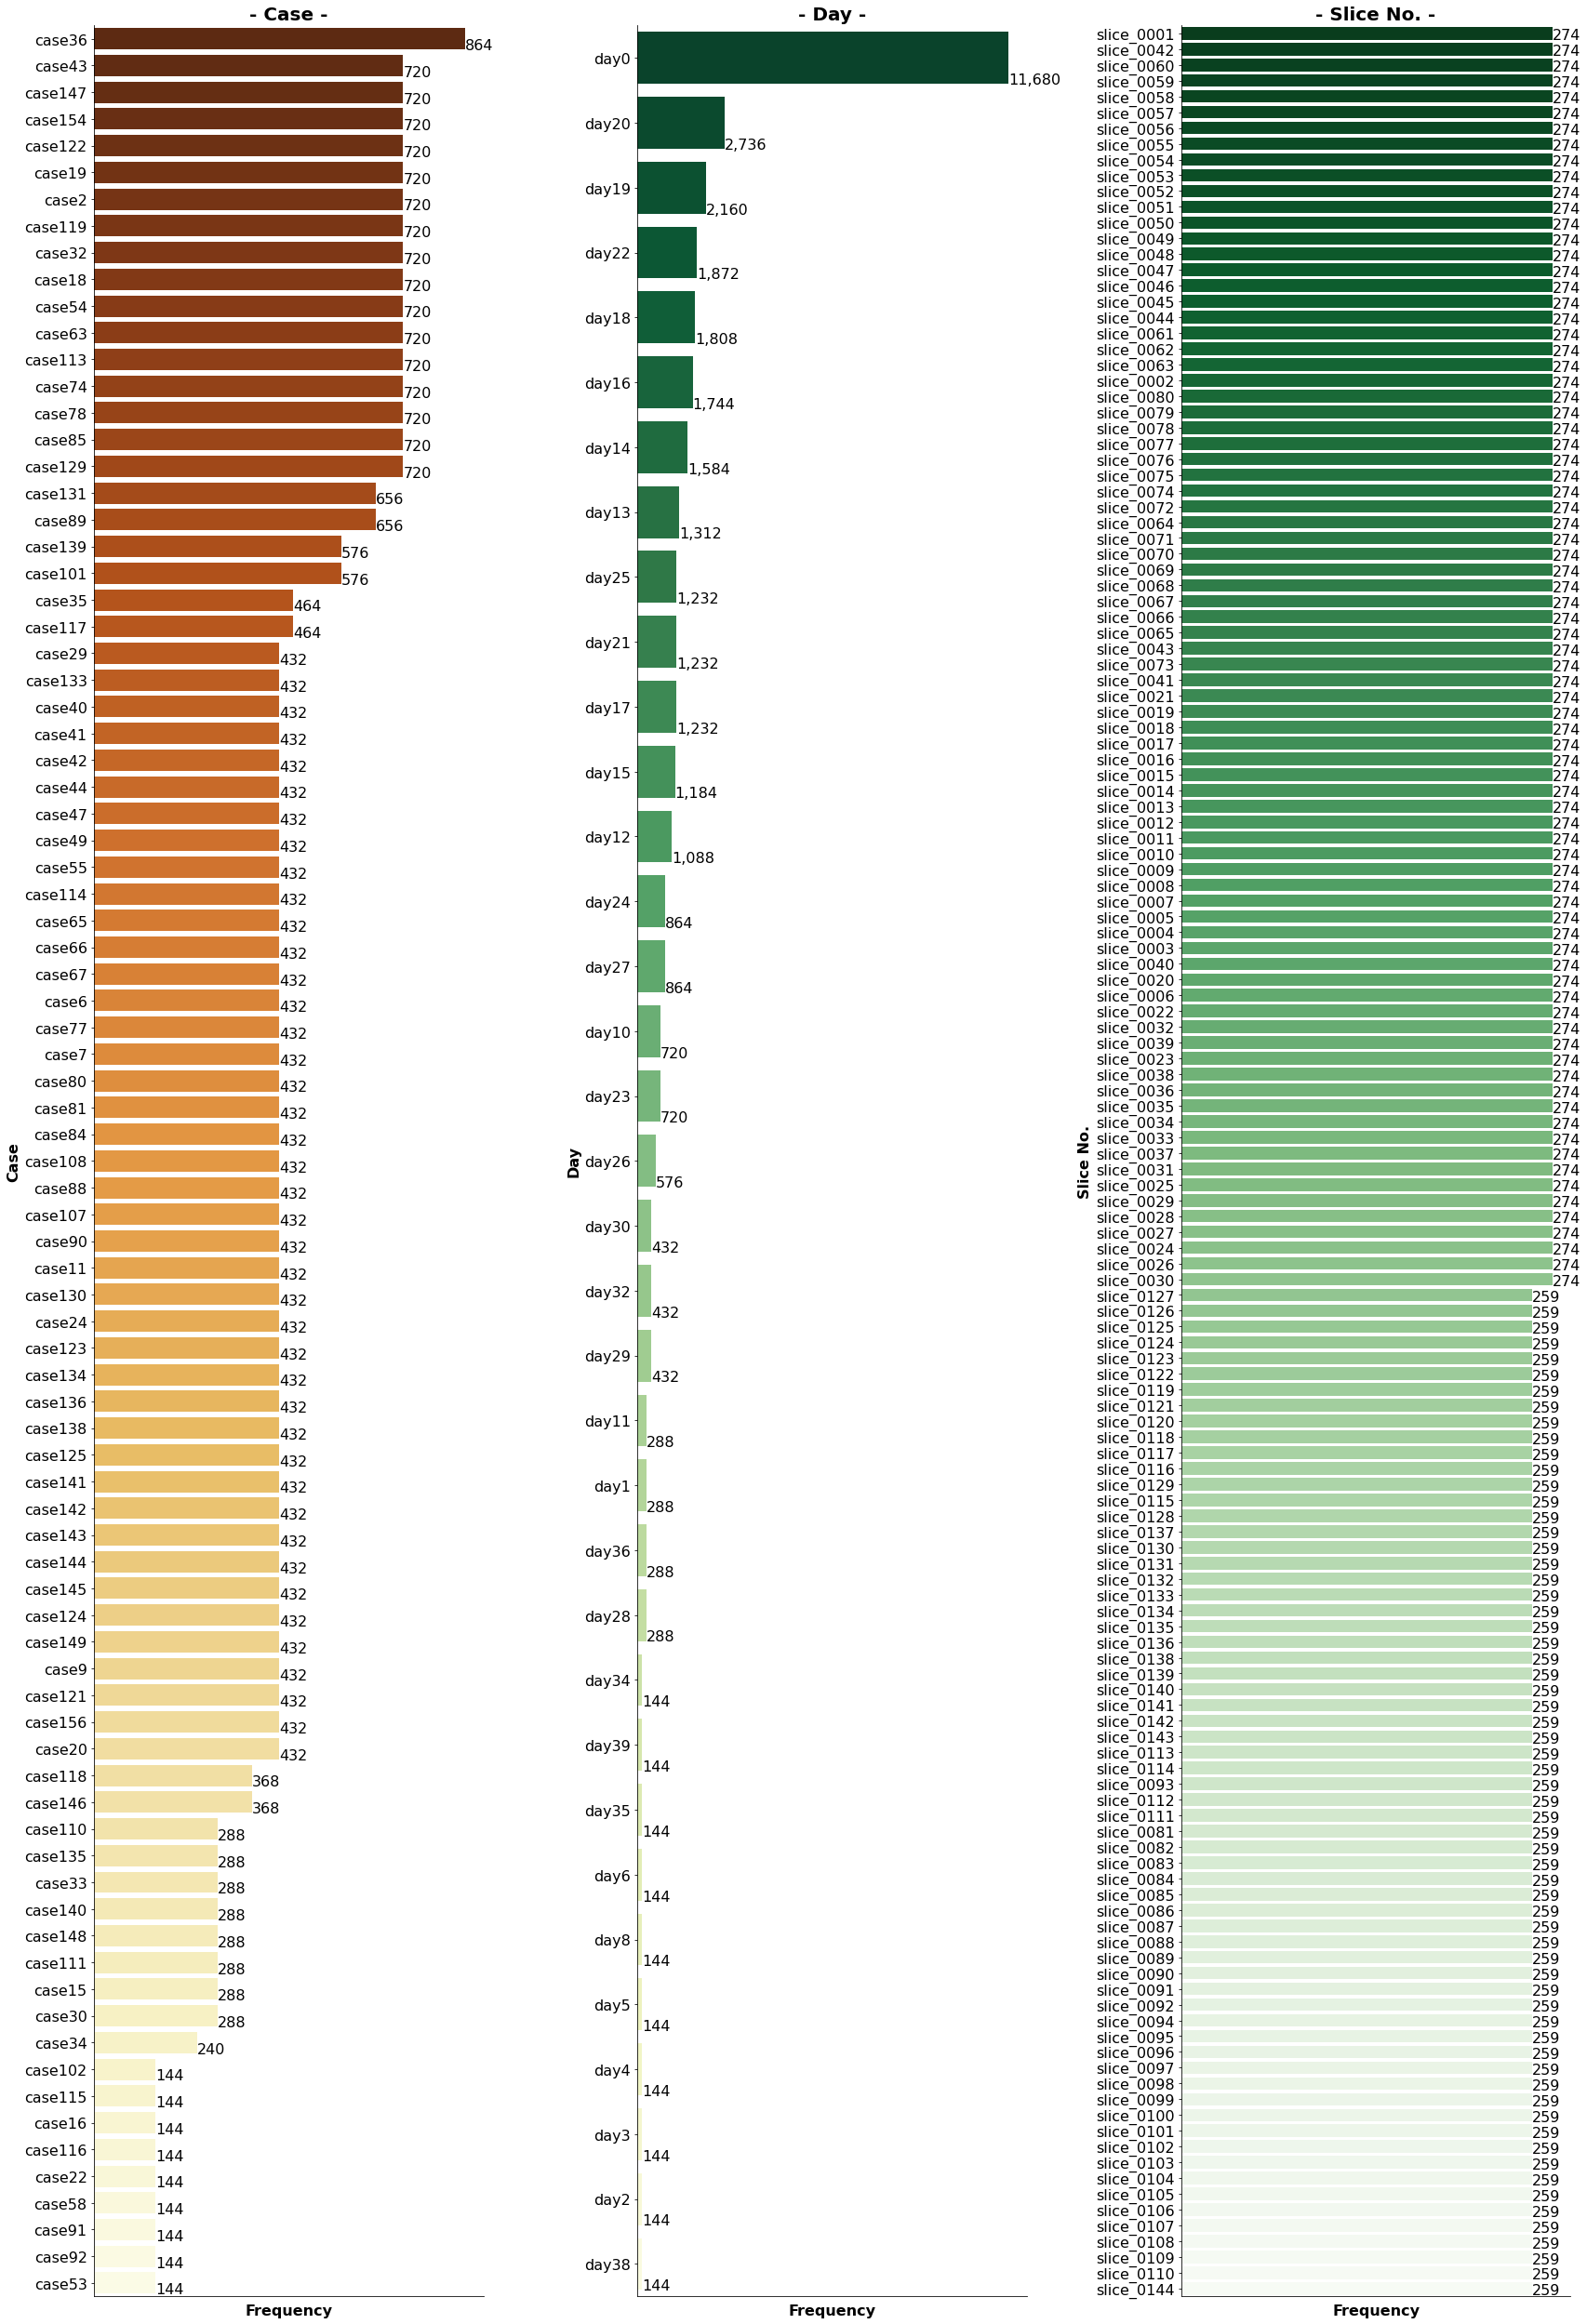

In [6]:
# Make the columns unique
# as they repeat sometimes due to multiple "class" values
data = train_data.groupby("id")[["case", "day", "slice"]].first().reset_index()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 35))
titles = ["Case", "Day", "Slice No."]

sns.barplot(data=data["case"].value_counts().reset_index(),
            y="index", x="case", ax=ax1, 
            palette="YlOrBr_r")

sns.barplot(data=data["day"].value_counts().reset_index(),
            y="index", x="day", ax=ax2,
            palette="YlGn_r")

sns.barplot(data=data["slice"].value_counts().reset_index(),
            y="index", x="slice", ax=ax3,
            palette="Greens_r")

for ax, t in zip([ax1, ax2, ax3], titles):
    show_values_on_bars(ax, h_v="h", space=0.4)
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_xlabel("Frequency", weight="bold")
    ax.set_ylabel(f"{t}", weight="bold")
    ax.get_xaxis().set_ticks([]);
    
sns.despine()
fig.tight_layout();

In [7]:
# Get only case and day data
# Creating a new dataframe and extracting only the number
# from the 2 columns
case_day = pd.DataFrame({"case" : train_data["case"].apply(lambda x: int("".join([i for i in x if i.isdigit()]))),
                         "day" : train_data["day"].apply(lambda x: int("".join([i for i in x if i.isdigit()])))})

# Sepparate 2 dataframes
# one containing average days per case & the other count of days per case
day_mean = case_day.groupby("case")["day"].mean().reset_index()
day_count = case_day.groupby("case")["day"].unique().reset_index()
day_count["day"] = day_count["day"].apply(lambda x: len(x))

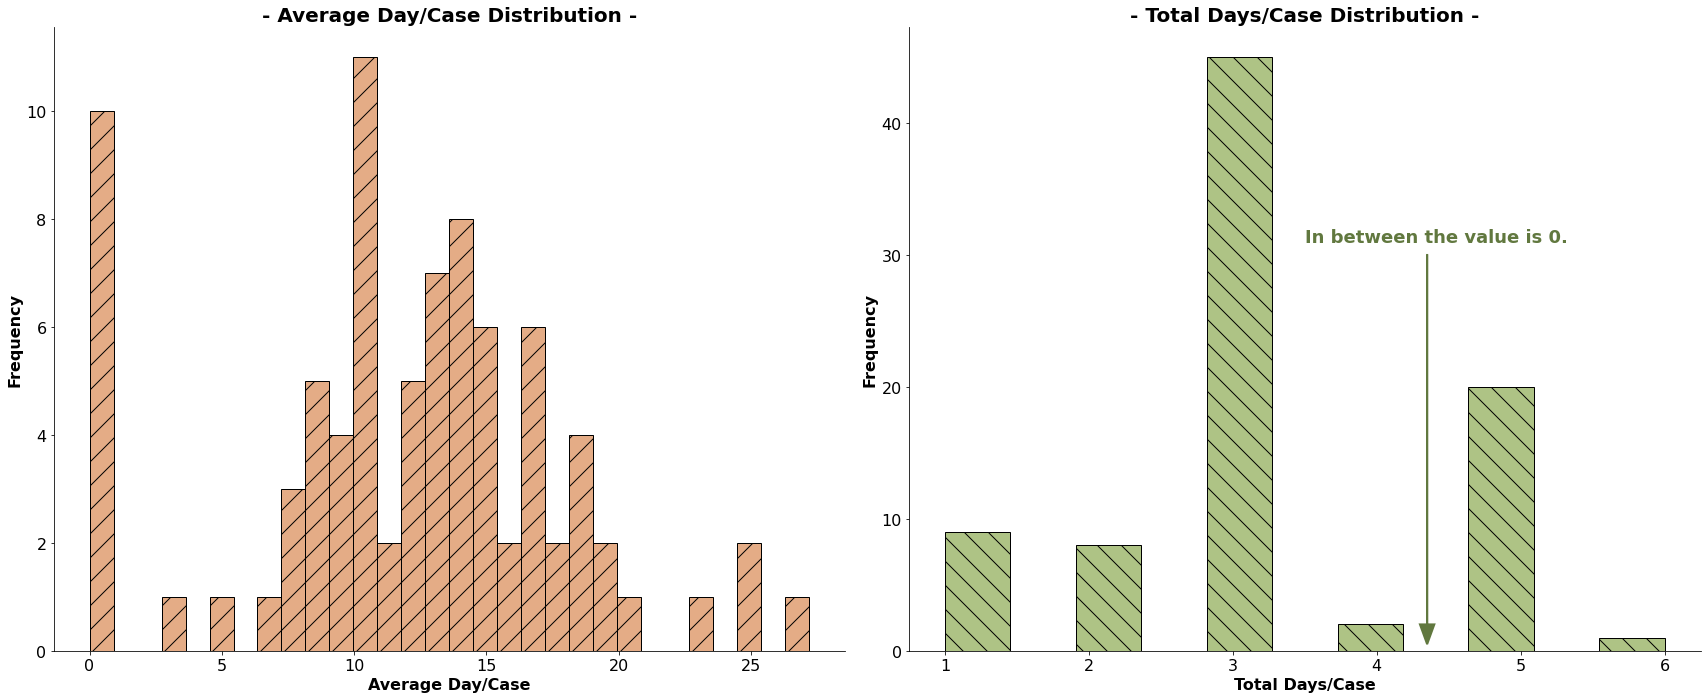

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
titles = ["Average Day/Case Distribution", "Total Days/Case Distribution"]
# hatches = itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'])

sns.histplot(data=day_mean, x="day",bins=30, color=my_colors[1], ax=ax1)

sns.histplot(data=day_count, x="day", color=my_colors[3], ax=ax2)

for ax, t, label in zip([ax1, ax2], titles, ["Average Day/Case", "Total Days/Case"]):
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_xlabel(f"{label}", weight="bold")
    ax.set_ylabel("Frequency", weight="bold")
    

for i, bar in enumerate(ax1.patches):
    bar.set_hatch("/")
#     bar.set_edgecolor(my_colors[0])
    
for i, bar in enumerate(ax2.patches):
    bar.set_hatch("\\")
    
ax2.arrow(x=4.35, y=30, dx=0, dy=-28, head_width=0.1, head_length=1.5,
          color=my_colors[-1], linewidth=2)
ax2.text(x=3.5, y=31, s="In between the value is 0.", size=18, 
         color=my_colors[-1], weight="bold")
    
sns.despine()
fig.tight_layout();

**- Frequency between Days -**

**Average Day per Case:**

* Most of the cases were taken on average between day10 and day20

**Total Days/Case:**

* The total number of unique days per case varies between 1 and 6
* The majority of the cases have data taken for ~ 3 and 5 days in total.

In [9]:
def get_image_path(base_path, df):
    '''Gets the case, day, slice_no and path of the dataset (either train or test).
    base_path: path to train image folder
    return :: modified dataframe'''

    df["path"] = 0
    
    n = len(df)

    # Loop through entire dataset
    for k in tqdm(range(n)):
        data = df.iloc[k, :]
        segmentation = data.segmentation

        # In case coordinates for healthy tissue are present
        if pd.isnull(train_data.iloc[k, 2]) == False:
            case = data.case
            day = data.day
            slice = data.slice
            # Change value to the correct one
            df.loc[k, "path"] = glob.glob(f"{base_path}/{case}/{case}_{day}/scans/{slice}*")[0]
            
    return df

In [10]:
# BASE path (for train)
base_path = "../input/uw-madison-gi-tract-image-segmentation/train"

# Prep and save file
train_data = get_image_path(base_path, df=train_data)

100%|██████████| 115488/115488 [02:07<00:00, 907.51it/s] 


In [11]:
# Retrieve image width and height
train_data["image_width"] = train_data["path"].apply(lambda x: get_img_size(x, "width"))
train_data["image_height"] = train_data["path"].apply(lambda x: get_img_size(x, "height"))

train_data["pixel_width"] = train_data["path"].apply(lambda x: get_pixel_size(x, "width"))
train_data["pixel_height"] = train_data["path"].apply(lambda x: get_pixel_size(x, "height"))

train_data.head(3)

id        class segmentation     case    day  \
0  case123_day20_slice_0001  large_bowel          NaN  case123  day20   
1  case123_day20_slice_0001  small_bowel          NaN  case123  day20   
2  case123_day20_slice_0001      stomach          NaN  case123  day20   

        slice path  image_width  image_height  pixel_width  pixel_height  
0  slice_0001    0            0             0          0.0           0.0  
1  slice_0001    0            0             0          0.0           0.0  
2  slice_0001    0            0             0          0.0           0.0

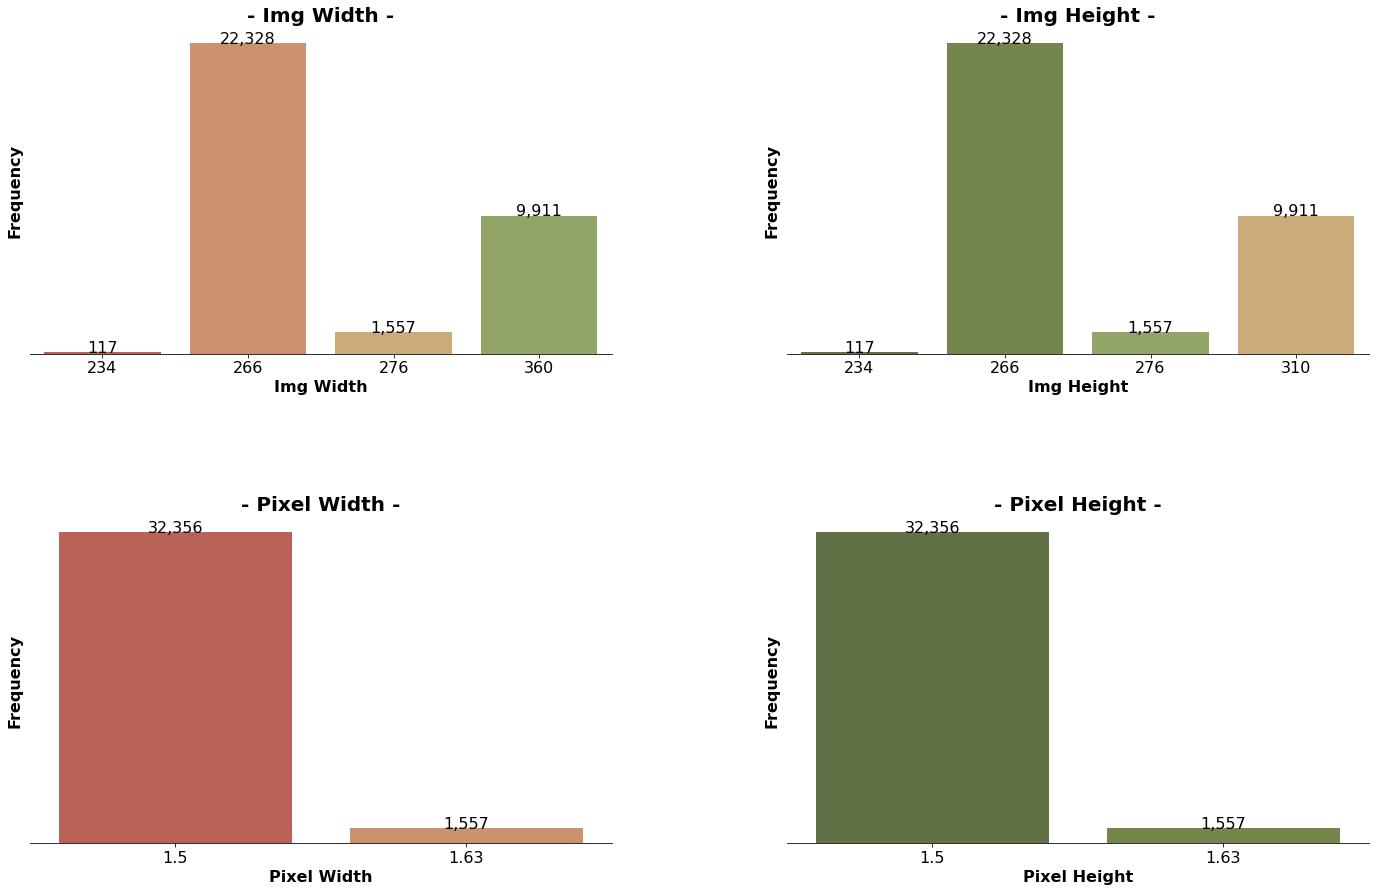

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 15))
titles = ["Img Width", "Img Height", "Pixel Width", "Pixel Height"]

dt = train_data[train_data["image_width"] != 0.0].reset_index(drop=True)

sns.barplot(data=dt["image_width"].value_counts().reset_index(),
            x="index", y="image_width", ax=ax1, 
            palette=my_colors)

sns.barplot(data=dt["image_height"].value_counts().reset_index(),
            x="index", y="image_height", ax=ax2,
            palette=my_colors[::-1])

sns.barplot(data=dt["pixel_width"].value_counts().reset_index(),
            x="index", y="pixel_width", ax=ax3, 
            palette=my_colors)

sns.barplot(data=dt["pixel_height"].value_counts().reset_index(),
            x="index", y="pixel_height", ax=ax4,
            palette=my_colors[::-1])

for ax, t in zip([ax1, ax2, ax3, ax4], titles):
    show_values_on_bars(ax, h_v="v", space=0.4)
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_ylabel("Frequency", weight="bold")
    ax.set_xlabel(f"{t}", weight="bold")
    ax.get_yaxis().set_ticks([]);
    
sns.despine(left=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5);

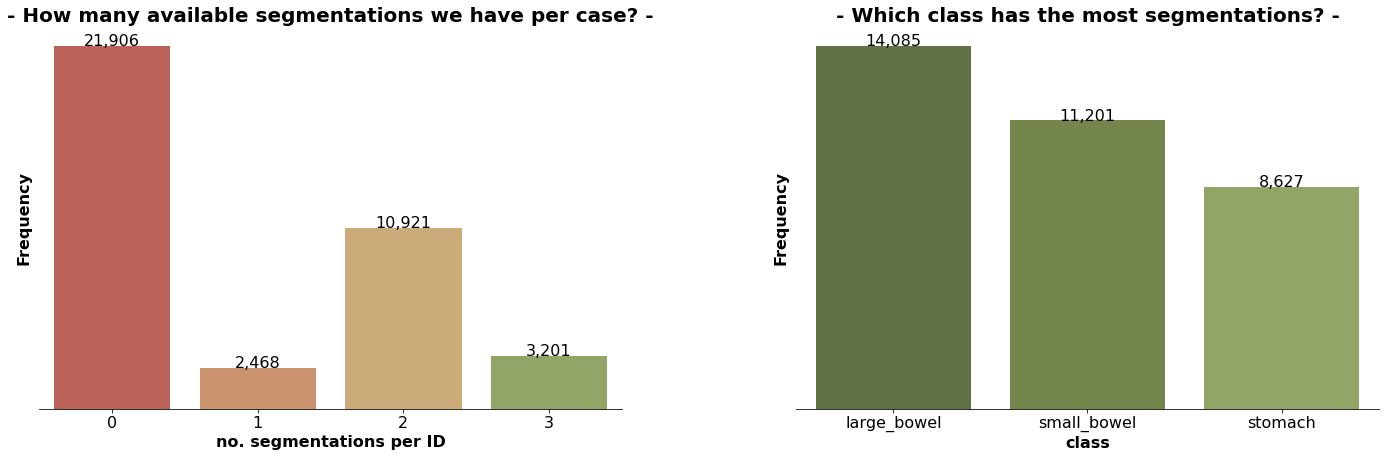

In [13]:
# Data
segment_per_id = train_data.groupby("id")["segmentation"].count()\
                    .reset_index()["segmentation"].value_counts().reset_index()

segment_per_class = train_data.groupby("class")["segmentation"].count().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 7))
titles = ["How many available segmentations we have per case?",
          "Which class has the most segmentations?"]


sns.barplot(data=segment_per_id,
            x="index", y="segmentation", ax=ax1, 
            palette=my_colors)

sns.barplot(data=segment_per_class,
            x="class", y="segmentation", ax=ax2,
            palette=my_colors[::-1])


for ax, t, x in zip([ax1, ax2], titles, ["no. segmentations per ID", "class"]):
    show_values_on_bars(ax, h_v="v", space=0.4)
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_ylabel("Frequency", weight="bold")
    ax.set_xlabel(f"{x}", weight="bold")
    ax.get_yaxis().set_ticks([]);
    
sns.despine(left=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5);

In [14]:
def read_image(path):
    '''Reads and converts the image.
    path: the full complete path to the .png file'''

    # Read image in a corresponding manner
    # convert int16 -> float32
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype('float32')
    # Scale to [0, 255]
    image = cv2.normalize(image, None, alpha = 0, beta = 255, 
                        norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    image = image.astype(np.uint8)
    
    return image

def show_simple_images(sample_paths, image_names="sample_images"):
    '''Displays simple images (without mask).'''

    # Get additional info from the path
    case_name = [info.split("_")[0][-7:] for info in sample_paths]
    day_name = [info.split("_")[1].split("/")[0] for info in sample_paths]
    slice_name = [info.split("_")[2] for info in sample_paths]


    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 8))
    axs = axs.flatten()

    for k, path in enumerate(sample_paths):
        title = f"{k+1}. {case_name[k]} - {day_name[k]} - {slice_name[k]}"
        axs[k].set_title(title, fontsize = 14, 
                         color = my_colors[-1], weight='bold')

        img = read_image(path)
        axs[k].imshow(img)
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()

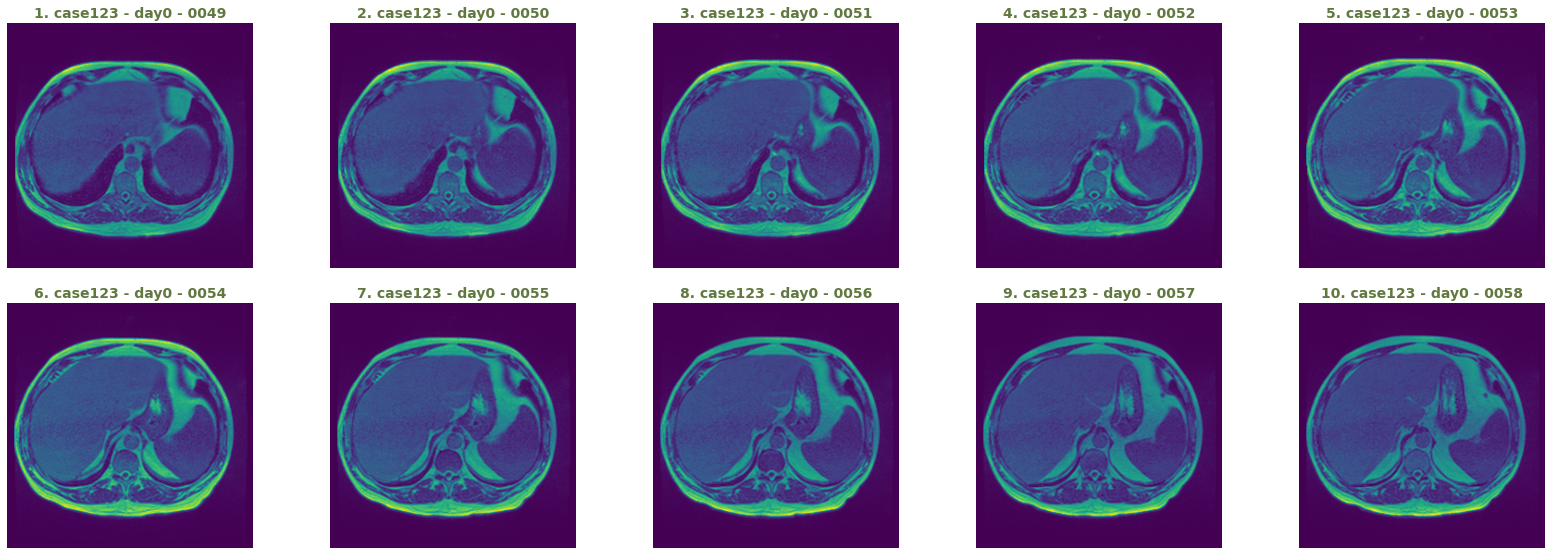

In [15]:
CASE = "case123"

# Sample a few images from speciffied case
sample_paths1 = train_data[(train_data["segmentation"].isna()==False) & (train_data["case"]==CASE)]["path"]\
                .reset_index().groupby("path")["index"].count()\
                .reset_index().loc[:9, "path"].tolist()

show_simple_images(sample_paths1, image_names="case123_samples")

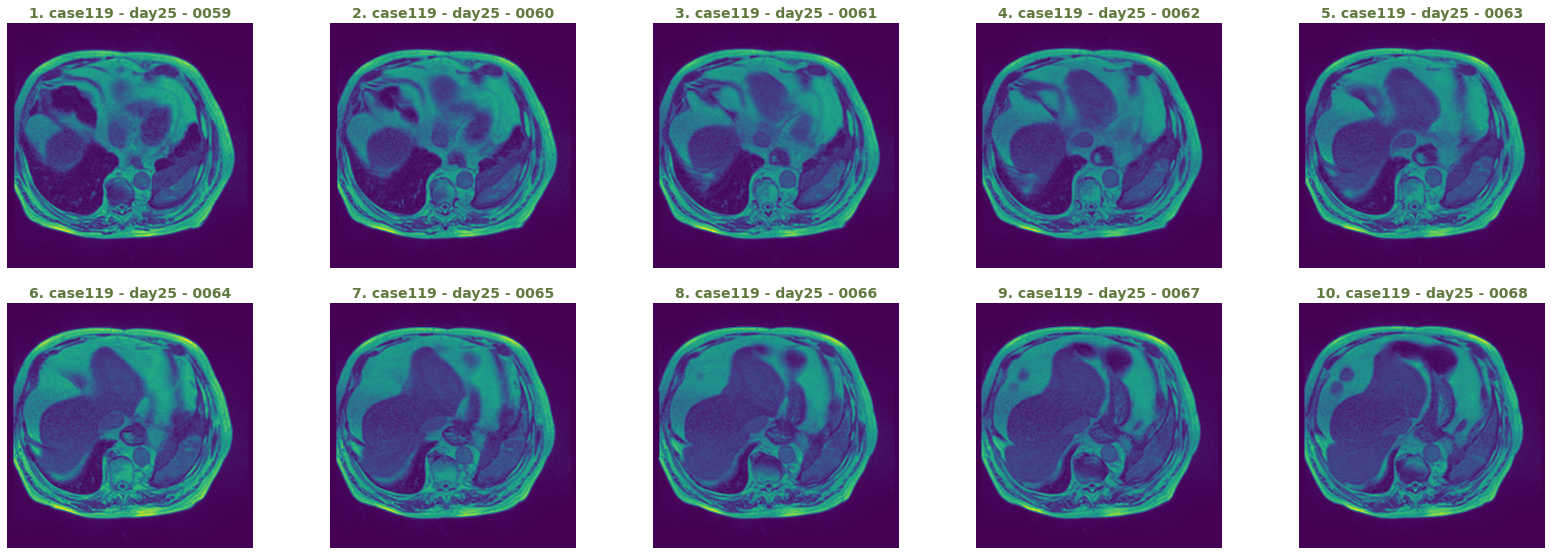

In [16]:
DAY = "day25"

# Sample a few images from speciffied case
sample_paths2 = train_data[(train_data["segmentation"].isna()==False) & (train_data["day"]==DAY)]["path"]\
                .reset_index().groupby("path")["index"].count()\
                .reset_index().loc[:9, "path"].tolist()

show_simple_images(sample_paths2, image_names="day25_samples")

In [17]:
def mask_from_segmentation(segmentation, shape):
    '''Returns the mask corresponding to the inputed segmentation.
    segmentation: a list of start points and lengths in this order
    max_shape: the shape to be taken by the mask
    return:: a 2D mask'''

    # Get a list of numbers from the initial segmentation
    segm = np.asarray(segmentation.split(), dtype=int)

    # Get start point and length between points
    start_point = segm[0::2] - 1
    length_point = segm[1::2]

    # Compute the location of each endpoint
    end_point = start_point + length_point

    # Create an empty list mask the size of the original image
    # take onl
    case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Change pixels from 0 to 1 that are within the segmentation
    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 1

    case_mask = case_mask.reshape((shape[0], shape[1]))
    
    return case_mask

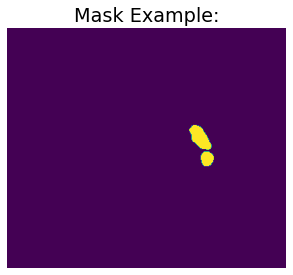

In [18]:
segmentation = '45601 5 45959 10 46319 12 46678 14 47037 16 47396 18 47756 18 48116 19 48477 18 48837 19 \
                49198 19 49558 19 49919 19 50279 20 50639 20 50999 21 51359 21 51719 22 52079 22 52440 22 52800 22 53161 21 \
                53523 20 53884 20 54245 19 54606 19 54967 18 55328 17 55689 16 56050 14 56412 12 56778 4 57855 7 58214 9 58573 12 \
                58932 14 59292 15 59651 16 60011 17 60371 17 60731 17 61091 17 61451 17 61812 15 62172 15 62532 15 62892 14 \
                63253 12 63613 12 63974 10 64335 7'

shape = (310, 360)
case_mask = mask_from_segmentation(segmentation, shape)
plt.figure(figsize=(5, 5))
plt.title("Mask Example:")
plt.imshow(case_mask)
plt.axis("off")
plt.show();



In [19]:
def get_id_mask(ID, verbose=False):
    '''Returns a mask for each case ID. If no segmentation was found, the mask will be empty
    - meaning formed by only 0
    ID: the case ID from the train.csv file
    verbose: True if we want any prints
    return: segmentation mask'''

    # ~~~ Get the data ~~~
    # Get the portion of dataframe where we have ONLY the speciffied ID
    ID_data = train_data[train_data["id"]==ID].reset_index(drop=True)

    # Split the dataframe into 3 series of observations
    # each for one speciffic class - "large_bowel", "small_bowel", "stomach"
    observations = [ID_data.loc[k, :] for k in range(3)]


    # ~~~ Create the mask ~~~
    # Get the maximum height out of all observations
    # if max == 0 then no class has a segmentation
    # otherwise we keep the length of the mask
    max_height = np.max([obs.image_height for obs in observations])
    max_width = np.max([obs.image_width for obs in observations])

    # Get shape of the image
    # 3 channels of color/classes
    shape = (max_height, max_width, 3)

    # Create an empty mask with the shape of the image
    mask = np.zeros(shape, dtype=np.uint8)

    # If there is at least 1 segmentation found in the group of 3 classes
    if max_height != 0:
        for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
            observation = observations[k]
            segmentation = observation.segmentation

            # If a segmentation is found
            # Append a new channel to the mask
            if pd.isnull(segmentation) == False:
                mask[..., k] = mask_from_segmentation(segmentation, shape)

    # If no segmentation was found skip
    elif max_segmentation == 0:
        mask = None
        if verbose:
            print("None of the classes have segmentation.")
            
    return mask

In [20]:
# Full Example

# Read image
path = '../input/uw-madison-gi-tract-image-segmentation/train/case131/case131_day0/scans/slice_0066_360_310_1.50_1.50.png'
img = read_image(path)

# Get mask
ID = "case131_day0_slice_0066"
mask = get_id_mask(ID, verbose=False)

In [21]:
def plot_original_mask(img, mask, alpha=1):

    # Change pixels - when 1 make True, when 0 make NA
    mask = np.ma.masked_where(mask == 0, mask)

    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]


    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Original
    ax1.set_title("Original Image")
    ax1.imshow(img)
    ax1.axis("off")

    # With Mask
    ax2.set_title("Image with Mask")
    ax2.imshow(img)
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
    plt.show()
    
# --- Custom Color Maps ---
# Yellow Purple Red
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
labels = ["Large Bowel", "Small Bowel", "Stomach"]

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

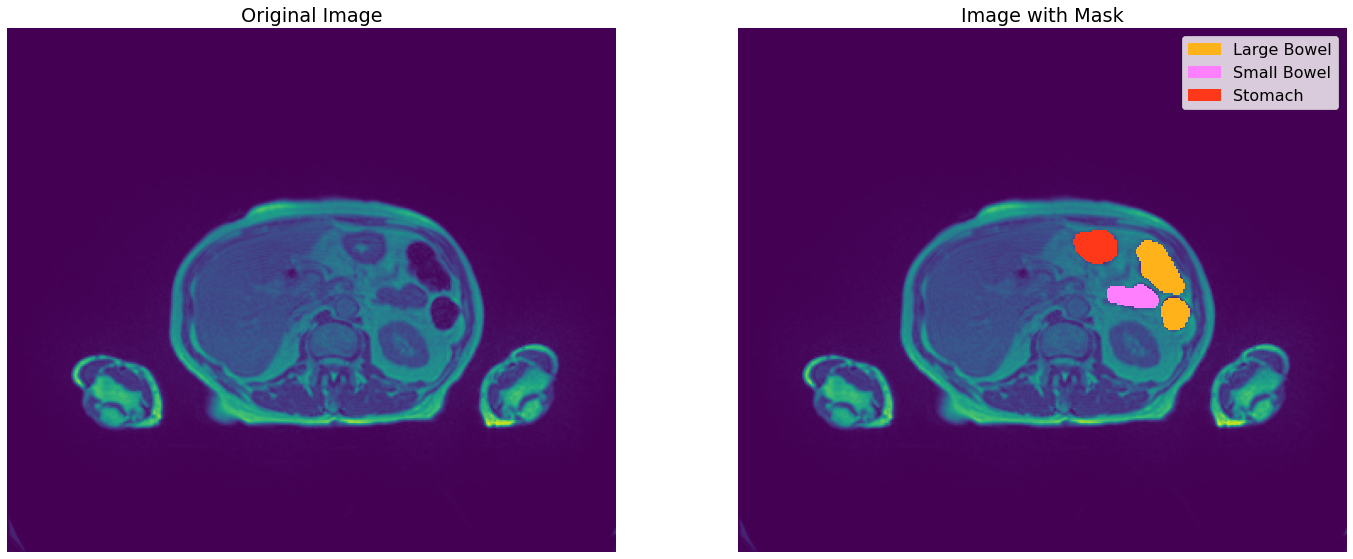

In [22]:
plot_original_mask(img, mask, alpha=1)

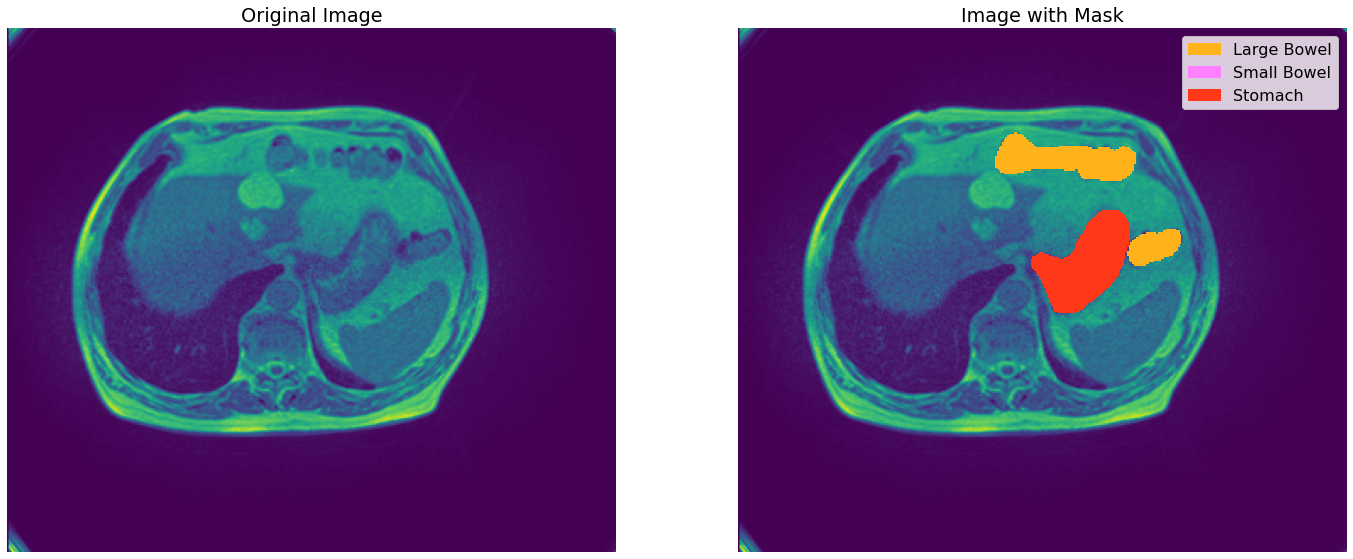

In [23]:
# Another example
path = '../input/uw-madison-gi-tract-image-segmentation/train/case18/case18_day0/scans/slice_0069_360_310_1.50_1.50.png'
img = read_image(path)

ID = "case18_day0_slice_0069"
mask = get_id_mask(ID, verbose=False)

plot_original_mask(img, mask, alpha=1)

In [24]:
## Function to plot multiple images and masks in chronological order 

def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    
    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.ma.masked_where(mask == 0, mask)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = my_colors[-1], weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
    
    axs[0].legend(legend_colors, labels, loc=2)
    plt.tight_layout()
    plt.show()

In [25]:
data = train_data[train_data["segmentation"].isna()==False].reset_index(drop=True)
print("Data Shape : ",data.shape)
data.head()

Data Shape :  (33913, 11)


id    class  \
0  case123_day20_slice_0065  stomach   
1  case123_day20_slice_0066  stomach   
2  case123_day20_slice_0067  stomach   
3  case123_day20_slice_0068  stomach   
4  case123_day20_slice_0069  stomach   

                                        segmentation     case    day  \
0  28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...  case123  day20   
1  27561 8 27825 11 28090 13 28355 14 28620 15 28...  case123  day20   
2  15323 4 15587 8 15852 10 16117 11 16383 12 166...  case123  day20   
3  14792 5 15056 9 15321 11 15587 11 15852 13 161...  case123  day20   
4  14526 6 14789 12 15054 14 15319 16 15584 17 15...  case123  day20   

        slice                                               path  image_width  \
0  slice_0065  ../input/uw-madison-gi-tract-image-segmentatio...          266   
1  slice_0066  ../input/uw-madison-gi-tract-image-segmentatio...          266   
2  slice_0067  ../input/uw-madison-gi-tract-image-segmentatio...          266   
3  slice_0068  ../input/uw-madison-gi-tract-image-segmentatio...          266   
4  slice_0069  ../input/uw-madison-gi-tract-image-segmentatio...          266   

   image_height  pixel_width  pixel_height  
0           266          1.5           1.5  
1           266          1.5           1.5  
2           266          1.5           1.5  
3           266          1.5           1.5  
4           266          1.5           1.5

**Case 123 | Day 20 | Slices 0085 -> 0094**

* the stomach segmentation decreases by each slice
* the small bowel segmentation increases in size and doubles on the left side of the CT too
* the large bowel seems to be decreasing by each slice until it splits in 2 smaller portions

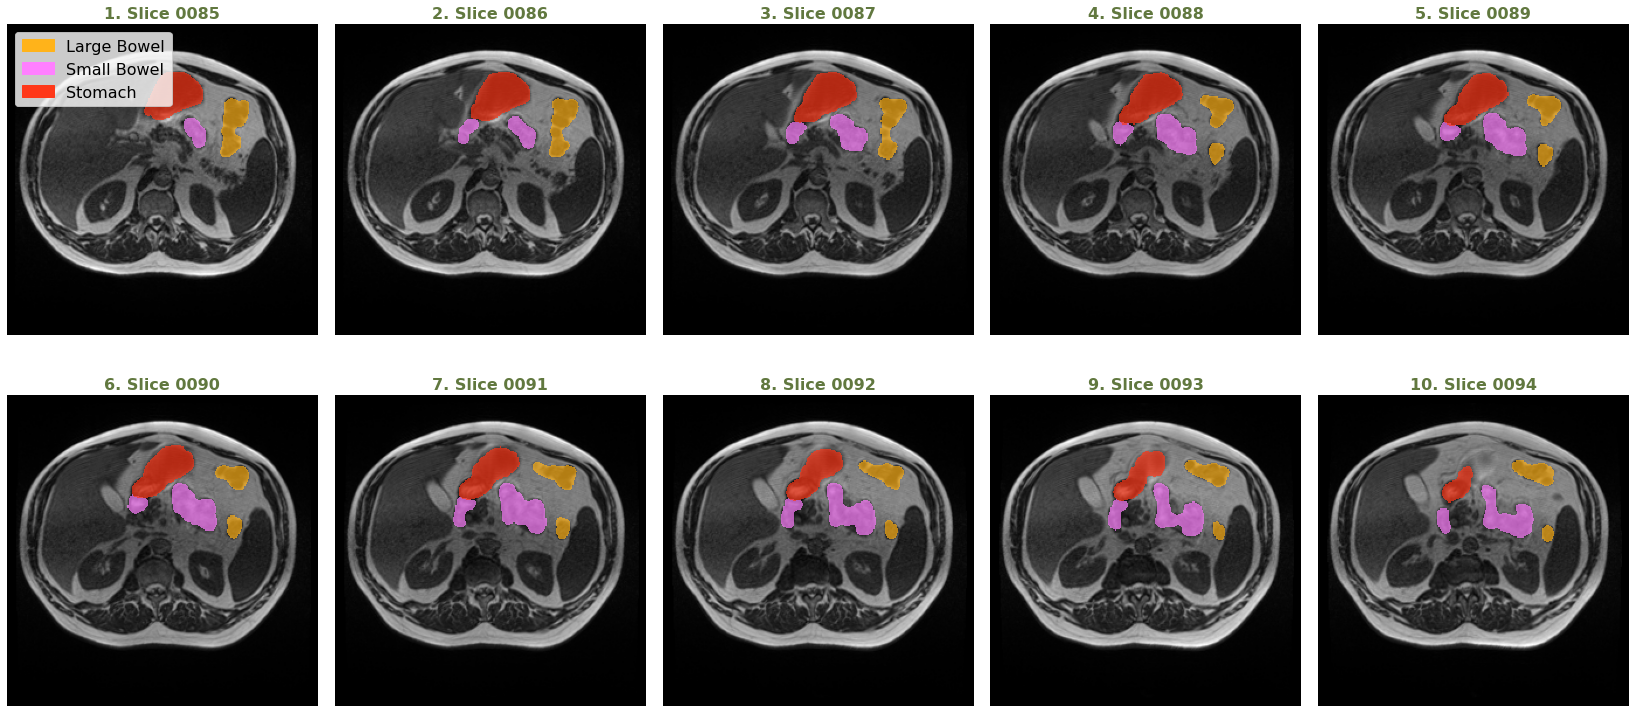

In [26]:
# Get random case
case = "case123"
day="day20"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().loc[20:29, :]

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i, verbose=False) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

**Case 30 | Day 0 | Slices 0092 -> 0101**

* the stomach segmentation appears in the second slice and starts increasing in size
* the small bowel segmentation is not present at all
* the large bowel increases in size too

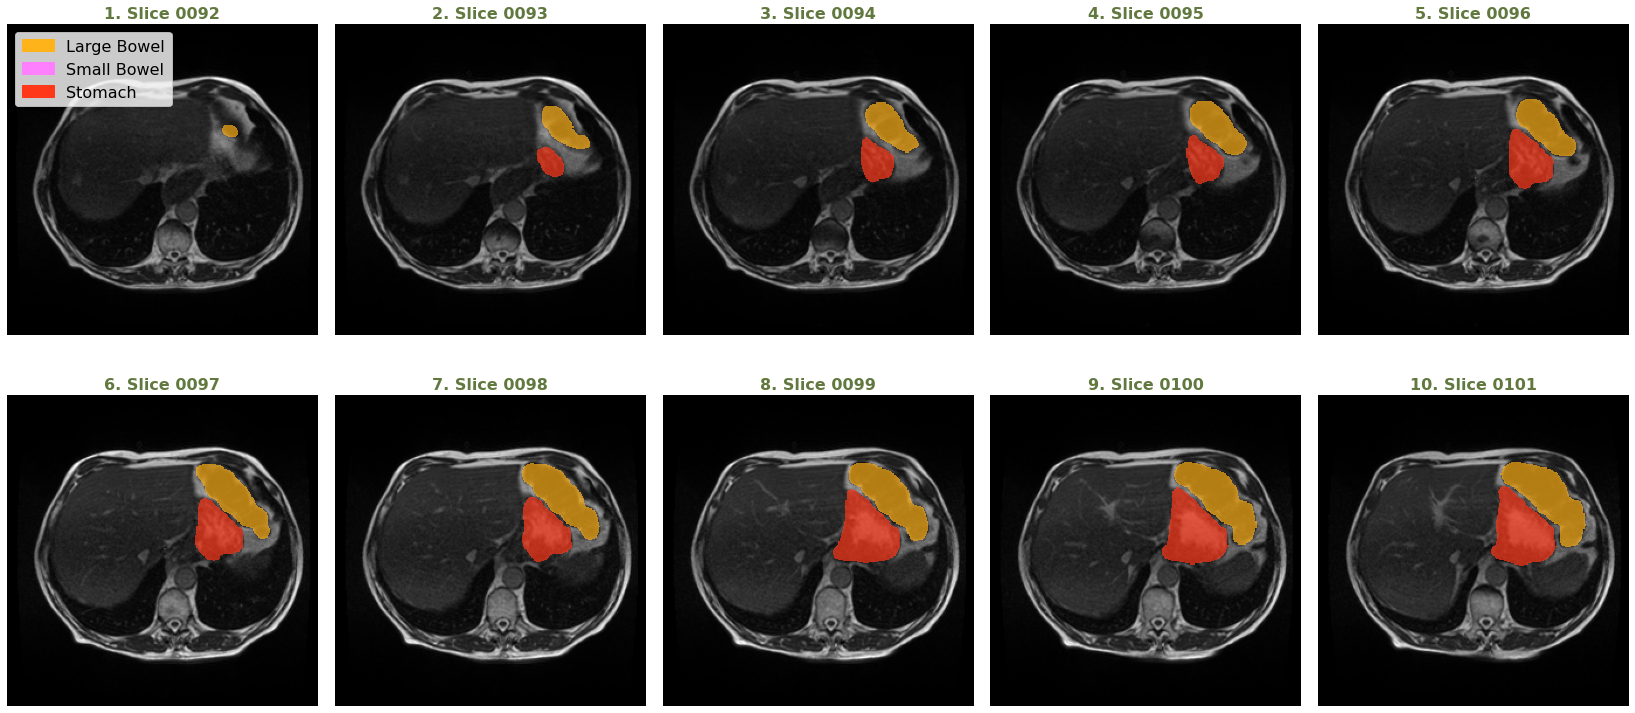

In [27]:
# Get random case
case = "case30"
day="day0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().head(10)

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i, verbose=False) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

**Case 18 | Day 0 | Slices 0060 -> 0069**

* the stomach segmentation increases by each slice
* the small bowel is not present in any of the slices
* the large bowel increases in size too and duplicates at some point next to the stomach too

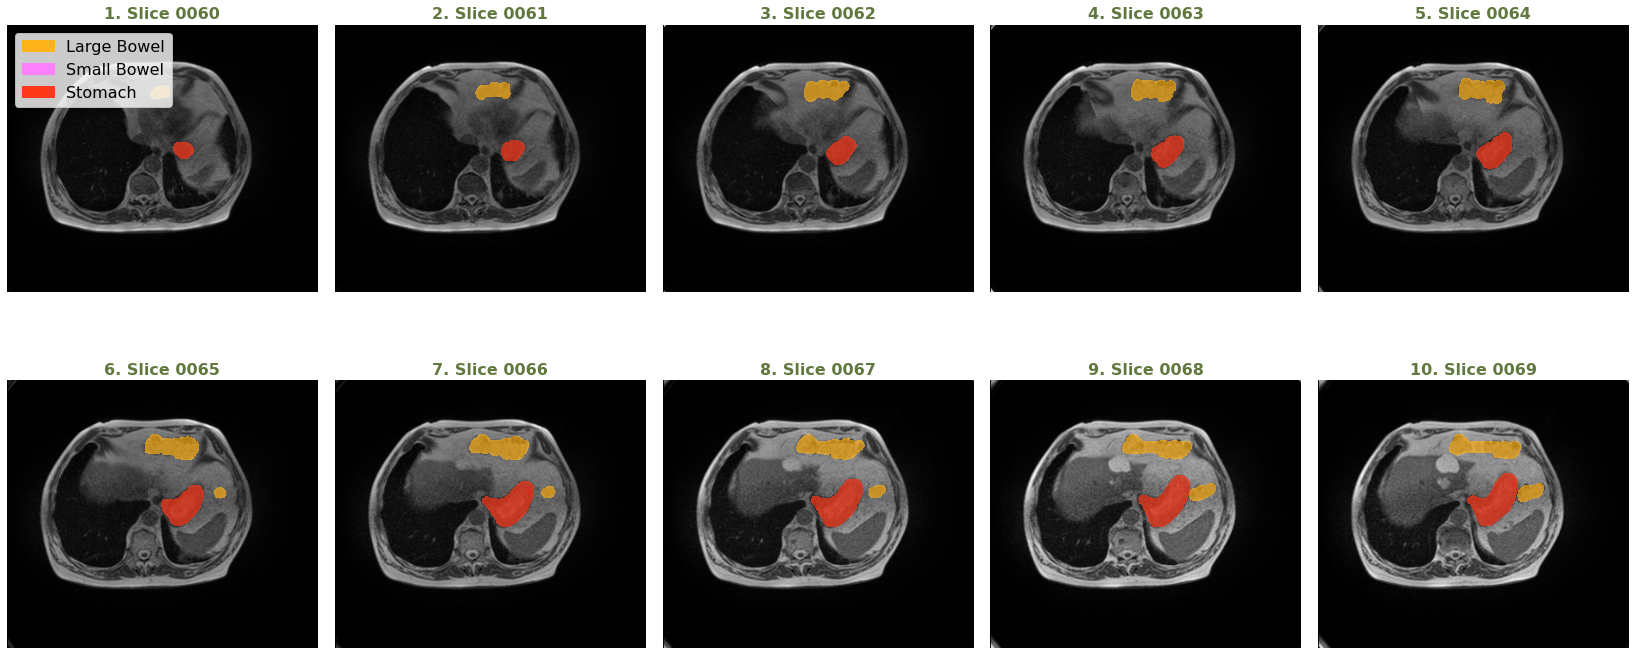

In [28]:
# Get random case
case = "case18"
day="day0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().head(10)

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i, verbose=False) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

**Case 146 | Day 0 | Slices 0080 -> 0089**

* the stomach segmentation is not present in any of the slices
* the small bowel segmentation has 2 locations and increases and splits in size by each slice (the last slice has 5 distinct locations where the healthy tissue is present)
* the large bowel increases in size, at some point 2 portions even unite in only one singural bigger piece

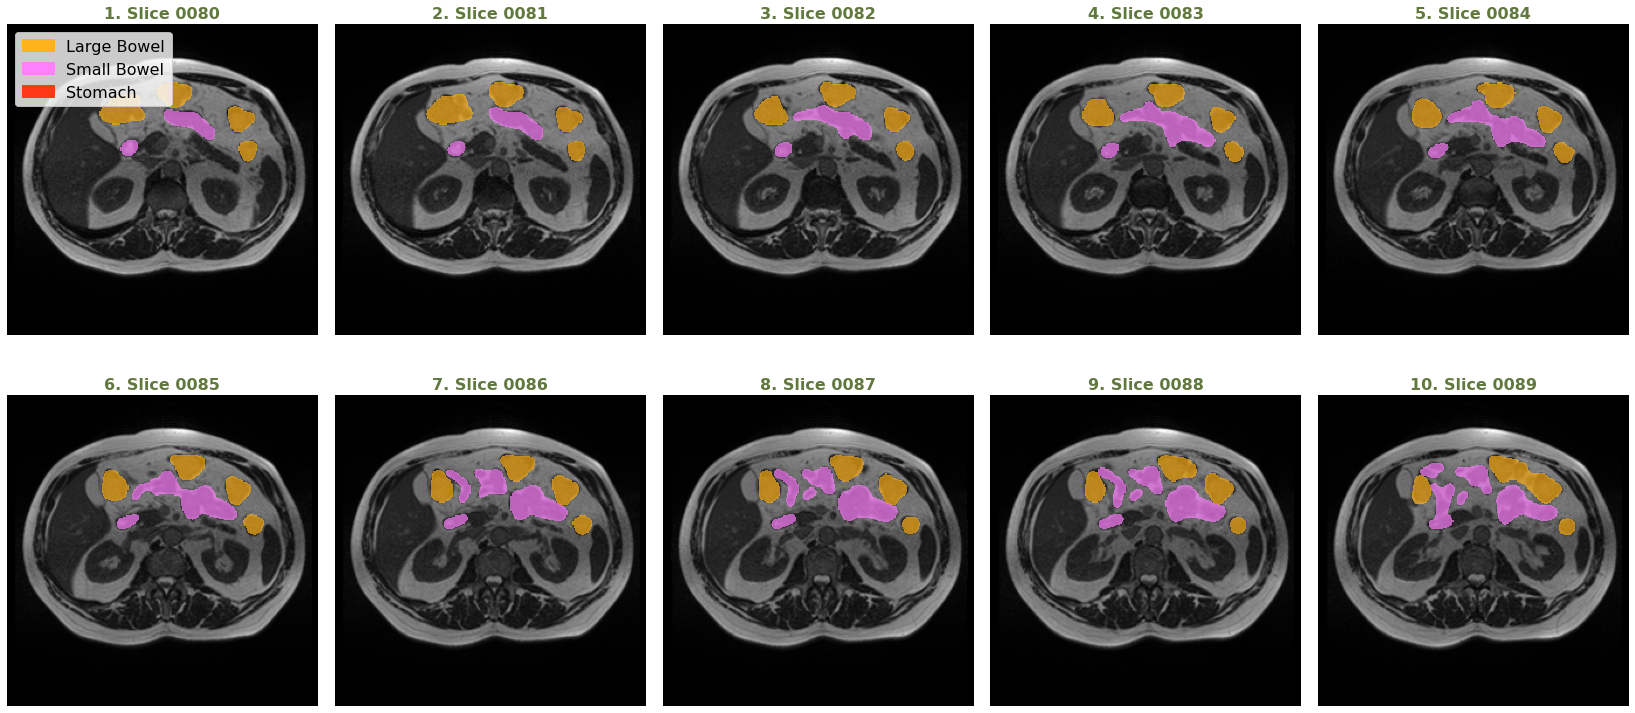

In [29]:
# Get random case
case = "case146"
day="day0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().loc[20:29, :]

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i, verbose=False) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)